# 01 — Preparación de datos y segmentación operacional

## Objetivo
Este notebook prepara un dataset **consistente y reproducible** para análisis físico posterior (eventos, ciclos y fatiga), a partir de mediciones de presión y caudal.

Se realizan las siguientes tareas:
1. Reindexación a grilla regular de **1 minuto**
2. Identificación de **faltantes** y **gaps** (tramos sin datos)
3. Diagnóstico de **saturación de caudal** (p.ej. $Q=Q_{\max}$)
4. Cálculo de incrementos $\Delta P$ y $\Delta Q$ **sin artefactos por gaps**
5. Segmentación operacional mediante **detección de cambios de régimen** en series suavizadas (1h)
6. Definición de umbrales iniciales (percentiles) para eventos operacionales

---

## Definiciones
Con intervalo de muestreo $\Delta t \approx 1$ min:

$$
\Delta P = P(t)-P(t-\Delta t), \qquad \Delta Q = Q(t)-Q(t-\Delta t)
$$

> Nota: El muestreo a minutos describe adecuadamente rampas, escalones y cambios de régimen. Transientes de segundos pueden quedar submuestreados.


In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

PROJECT_ROOT = Path('/home/maxi/datascience_esval')
BASE_FILE = PROJECT_ROOT / 'data' / 'processed' / 'sensores_base.parquet'

OUT_CLEAN = PROJECT_ROOT / 'data' / 'processed' / 'sensores_1min_clean.parquet'
OUT_SEG = PROJECT_ROOT / 'data' / 'processed' / 'segmentos_operacionales.parquet'

BASE_FILE.exists(), BASE_FILE


(True,
 PosixPath('/home/maxi/datascience_esval/data/processed/sensores_base.parquet'))

## 1) Carga del dataset base

In [13]:
df = pd.read_parquet(BASE_FILE)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.index.name = 't'

P_COL = 'p_bar'
Q_COL = 'q_lps'

df.shape, df.index.min(), df.index.max(), df.columns.tolist()


((475141, 7),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-11-27 00:00:00'),
 ['q_lps', 'q_m3s', 'h_mca', 'p_kpa', 'p_bar', 'dP_bar', 'dQ_lps'])

## 2) Grilla regular 1-min y flags de faltantes

Se construye una grilla completa de 1 minuto entre el primer y el último timestamp.  
Esto permite cuantificar faltantes reales y estandarizar el cálculo de incrementos.

Se agregan:
- `is_missing_p`, `is_missing_q`
- `is_missing_any`


In [14]:
t0, t1 = df.index.min(), df.index.max()
full_idx = pd.date_range(t0, t1, freq='1min', name='t')

g = df.reindex(full_idx)

g['is_missing_p'] = g[P_COL].isna()
g['is_missing_q'] = g[Q_COL].isna()
g['is_missing_any'] = g['is_missing_p'] | g['is_missing_q']

print('Filas originales:', len(df))
print('Filas grilla 1-min:', len(g))
g[[P_COL, Q_COL, 'is_missing_any']].head()


Filas originales: 475141
Filas grilla 1-min: 475201


,p_bar,q_lps,is_missing_any
t,,,
2025-01-01 00:00:00,1.734483,45.44,False
2025-01-01 00:01:00,1.741485,43.88,False
2025-01-01 00:02:00,1.759490,41.79,False
2025-01-01 00:03:00,1.760490,42.15,False
2025-01-01 00:04:00,1.738484,43.16,False


## 3) Gaps (tramos continuos sin datos)

Un *gap* es un tramo continuo donde faltan datos.  
Es importante detectarlos porque introducen artefactos al calcular diferencias (diff) si no se controlan.

Se calcula:
- identificador de run (`miss_run_id`)
- duración del run (`miss_run_len`)
- tabla de gaps con inicio/fin/duración


In [15]:
is_m = g['is_missing_any'].astype(bool)

# run-id: cada vez que cambia el estado missing/no-missing
g['miss_run_id'] = is_m.ne(is_m.shift()).cumsum()

# longitud del run para cada fila (vectorizado)
g['miss_run_len'] = g.groupby('miss_run_id')['is_missing_any'].transform('size').astype(int)

# gap_len solo donde hay missing
g['gap_len_min'] = np.where(is_m, g['miss_run_len'], 0).astype(int)

# tabla de gaps (vectorizada, sin groupby-apply lento)
tmp = g.reset_index()[['t','is_missing_any','miss_run_id','miss_run_len']]
gap_table = (tmp[tmp['is_missing_any']]
             .groupby('miss_run_id', as_index=False)
             .agg(start=('t','min'), end=('t','max'), gap_len_min=('miss_run_len','first'))
             .sort_values('gap_len_min', ascending=False))

print('n_gaps:', len(gap_table))
gap_table.head(10)


n_gaps: 1956


,miss_run_id,start,end,gap_len_min
788,1578,2025-09-15 19:32:00,2025-09-16 02:47:00,436
593,1188,2025-04-11 10:47:00,2025-04-11 15:38:00,292
226,454,2025-03-12 14:19:00,2025-03-12 19:02:00,284
134,270,2025-01-28 18:48:00,2025-01-28 22:45:00,238
158,318,2025-01-29 23:08:00,2025-01-30 02:52:00,225
757,1516,2025-08-17 07:13:00,2025-08-17 10:56:00,224
706,1414,2025-05-19 08:48:00,2025-05-19 12:15:00,208
139,280,2025-01-29 00:38:00,2025-01-29 03:13:00,156
106,214,2025-01-28 12:24:00,2025-01-28 14:42:00,139
237,476,2025-03-18 03:54:00,2025-03-18 06:04:00,131


## 4) Incrementos limpios: $\Delta P$ y $\Delta Q$

Para evitar artefactos por gaps:
- `dP_raw`, `dQ_raw` se calculan en la grilla completa
- `dP_clean`, `dQ_clean` solo se consideran válidos si:
  - el minuto actual no es missing
  - el minuto anterior no es missing


In [16]:
g['p_bar'] = g[P_COL]
g['q_lps'] = g[Q_COL]

g['dP_bar_raw'] = g['p_bar'].diff()
g['dQ_lps_raw'] = g['q_lps'].diff()

ok_prev = (~g['is_missing_any']) & (~g['is_missing_any'].shift(1).fillna(True))
g['dP_bar_clean'] = np.where(ok_prev, g['dP_bar_raw'], np.nan)
g['dQ_lps_clean'] = np.where(ok_prev, g['dQ_lps_raw'], np.nan)

g[['p_bar','q_lps','dP_bar_raw','dP_bar_clean','dQ_lps_raw','dQ_lps_clean']].head(12)


/tmp/ipykernel_302037/3718451383.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ok_prev = (~g['is_missing_any']) & (~g['is_missing_any'].shift(1).fillna(True))


,p_bar,q_lps,dP_bar_raw,dP_bar_clean,dQ_lps_raw,dQ_lps_clean
t,,,,,,
2025-01-01 00:00:00,1.734483,45.44,NaN,NaN,NaN,NaN
2025-01-01 00:01:00,1.741485,43.88,0.007002,0.007002,-1.56,-1.56
2025-01-01 00:02:00,1.759490,41.79,0.018005,0.018005,-2.09,-2.09
2025-01-01 00:03:00,1.760490,42.15,0.001000,0.001000,0.36,0.36
2025-01-01 00:04:00,1.738484,43.16,-0.022006,-0.022006,1.01,1.01
2025-01-01 00:05:00,1.720479,43.88,-0.018005,-0.018005,0.72,0.72
2025-01-01 00:06:00,1.734483,43.45,0.014004,0.014004,-0.43,-0.43
2025-01-01 00:07:00,1.731482,44.06,-0.003001,-0.003001,0.61,0.61
2025-01-01 00:08:00,1.727481,43.69,-0.004001,-0.004001,-0.37,-0.37


## 5) Diagnóstico de saturación de caudal

Se evalúa la fracción de tiempo donde $Q = Q_{\max}$ y su distribución temporal.


/tmp/ipykernel_302037/1166234055.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  qmax_by_month = g['is_q_at_max'].resample('1M').mean()


Q_max: 99.0
Frac(Q==Q_max): 2.104372675983426e-06


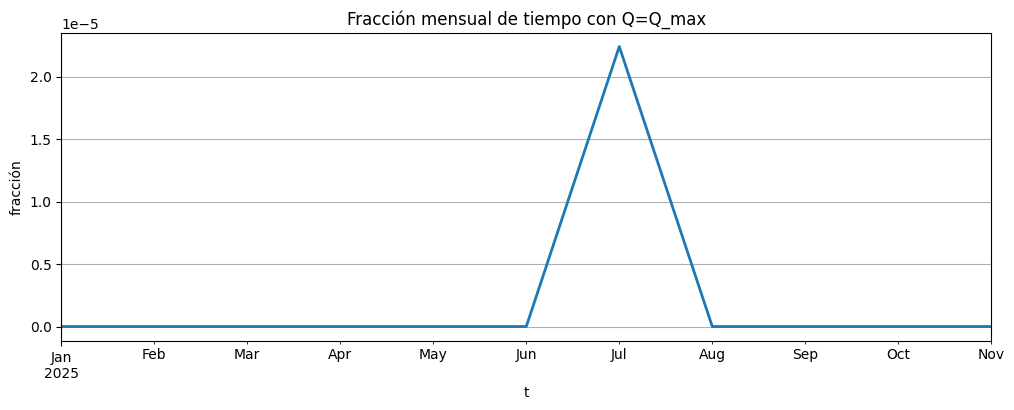

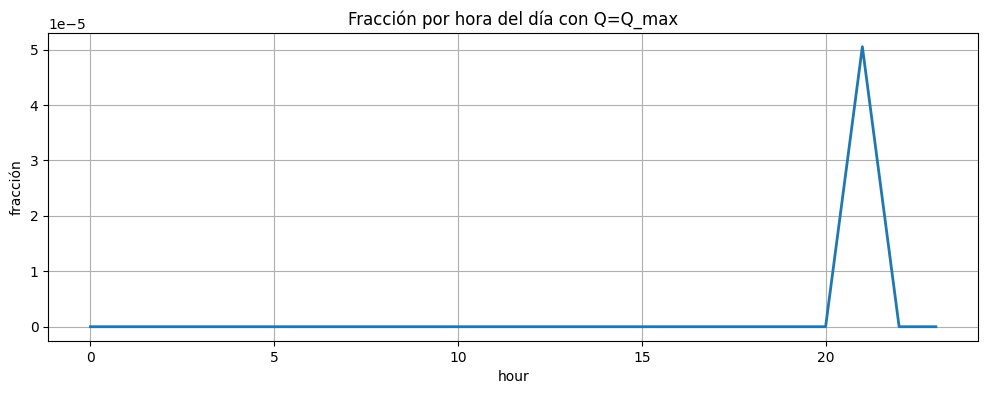

In [17]:
q_max = float(np.nanmax(g['q_lps'].values))
g['is_q_at_max'] = (g['q_lps'] == q_max)

print('Q_max:', q_max)
print('Frac(Q==Q_max):', float(g['is_q_at_max'].mean()))

qmax_by_month = g['is_q_at_max'].resample('1M').mean()
ax = qmax_by_month.plot(linewidth=2)
ax.set_title('Fracción mensual de tiempo con Q=Q_max')
ax.set_ylabel('fracción')
plt.show()

tmp = g[['is_q_at_max']].copy()
tmp['hour'] = tmp.index.hour
qmax_by_hour = tmp.groupby('hour')['is_q_at_max'].mean()
ax = qmax_by_hour.plot(linewidth=2)
ax.set_title('Fracción por hora del día con Q=Q_max')
ax.set_ylabel('fracción')
plt.show()


## 6) Serie suavizada (1h) para segmentación operacional

La detección de cambios de régimen se realiza sobre series promediadas a 1 hora.


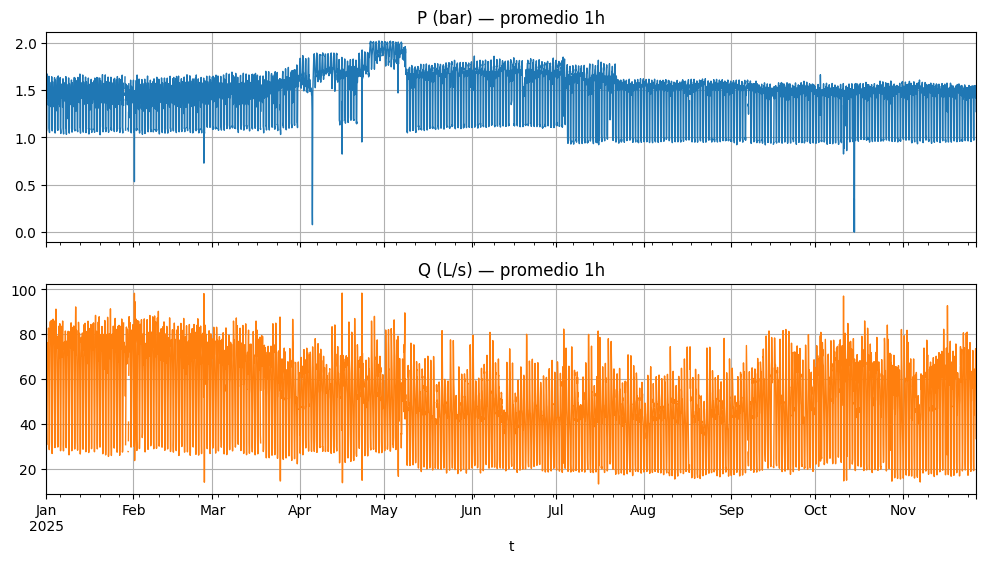

,count,mean,std,min,1%,5%,50%,95%,99%,max
p_bar,7887.0,1.462491,0.254107,0.000600,0.946930,0.974610,1.513938,1.815945,1.980743,2.018562
q_lps,7887.0,49.605021,19.082188,13.087167,16.926513,19.443667,50.775500,78.920000,84.832907,98.363833


In [18]:
g_1h = g[['p_bar','q_lps']].resample('1h').mean(numeric_only=True)

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
g_1h['p_bar'].plot(ax=ax[0], linewidth=1)
ax[0].set_title('P (bar) — promedio 1h')
g_1h['q_lps'].plot(ax=ax[1], linewidth=1, color='tab:orange')
ax[1].set_title('Q (L/s) — promedio 1h')
plt.show()

g_1h.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T


## 7) Segmentación por change-points (ruptures)

Se aplica `PELT` con modelo `l2` (cambios de nivel) sobre la señal multivariada estandarizada:

$$
Z(t) = \left[\frac{P(t)-\mu_P}{\sigma_P}, \frac{Q(t)-\mu_Q}{\sigma_Q}\right]
$$

El parámetro `pen` controla la cantidad de segmentos (mayor `pen` → menos segmentos).


In [19]:
x = g_1h[['p_bar','q_lps']].dropna()
z = (x - x.mean()) / x.std(ddof=0)
Z = z.values

pen = 12.0  # ajustable
algo = rpt.Pelt(model='l2').fit(Z)
bkps = algo.predict(pen=pen)  # endpoints (incluye len(x))

len(x), bkps[:10], len(bkps)


(7886, [10, 25, 30, 50, 55, 1045, 1050, 1760, 1770, 1785], 284)

### Tabla de segmentos operacionales

Para cada segmento:
- inicio / fin
- número de horas
- media y mediana de $P$ y $Q$ (1h)


In [20]:
idx = x.index
starts = [0] + bkps[:-1]
ends = bkps[:]

rows = []
for s, e in zip(starts, ends):
    seg = x.iloc[s:e]
    rows.append({
        'seg_id': len(rows),
        'start': seg.index.min(),
        'end': seg.index.max(),
        'n_hours': int(len(seg)),
        'p_bar_mean_1h': float(seg['p_bar'].mean()),
        'q_lps_mean_1h': float(seg['q_lps'].mean()),
        'p_bar_med_1h': float(seg['p_bar'].median()),
        'q_lps_med_1h': float(seg['q_lps'].median()),
    })

segments = pd.DataFrame(rows)
segments.head(), segments.shape


(   seg_id               start                 end  n_hours  p_bar_mean_1h  q_lps_mean_1h  p_bar_med_1h  q_lps_med_1h
 0       0 2025-01-01 00:00:00 2025-01-01 09:00:00       10       1.325846      38.455950      1.206269     37.186917
 1       1 2025-01-01 10:00:00 2025-01-02 00:00:00       15       1.479023      69.780689      1.468842     70.045333
 2       2 2025-01-02 01:00:00 2025-01-02 05:00:00        5       1.074599      30.841300      1.074699     30.019500
 3       3 2025-01-02 06:00:00 2025-01-03 01:00:00       20       1.423501      71.508190      1.433907     78.343452
 4       4 2025-01-03 02:00:00 2025-01-03 06:00:00        5       1.131265      29.989533      1.082051     27.993833,
 (284, 8))

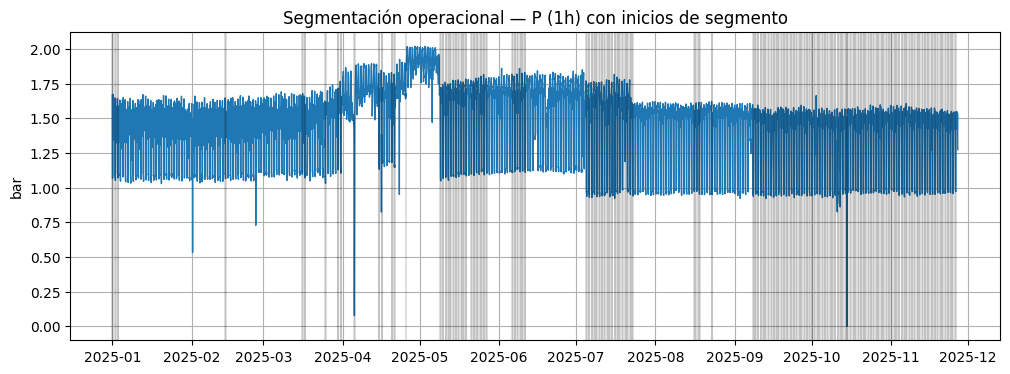

,seg_id,start,end,n_hours,p_bar_mean_1h,q_lps_mean_1h
0,0,2025-01-01 00:00:00,2025-01-01 09:00:00,10,1.325846,38.455950
1,1,2025-01-01 10:00:00,2025-01-02 00:00:00,15,1.479023,69.780689
2,2,2025-01-02 01:00:00,2025-01-02 05:00:00,5,1.074599,30.841300
3,3,2025-01-02 06:00:00,2025-01-03 01:00:00,20,1.423501,71.508190
4,4,2025-01-03 02:00:00,2025-01-03 06:00:00,5,1.131265,29.989533
5,5,2025-01-03 07:00:00,2025-02-14 00:00:00,990,1.378863,62.256636
6,6,2025-02-14 01:00:00,2025-02-14 05:00:00,5,1.085815,29.688500
7,7,2025-02-14 06:00:00,2025-03-15 23:00:00,710,1.406013,59.303826
8,8,2025-03-16 00:00:00,2025-03-16 09:00:00,10,1.339671,34.645807
9,9,2025-03-16 10:00:00,2025-03-17 00:00:00,15,1.453520,72.369425


In [21]:
plt.figure(figsize=(12,4))
plt.plot(x.index, x['p_bar'].values, linewidth=1, label='P 1h')

for _, r in segments.iterrows():
    plt.axvline(r['start'], color='k', alpha=0.12)

plt.title('Segmentación operacional — P (1h) con inicios de segmento')
plt.ylabel('bar')
plt.show()

segments[['seg_id','start','end','n_hours','p_bar_mean_1h','q_lps_mean_1h']].head(15)


## 8) Umbrales iniciales para eventos operacionales (percentiles)

Se calculan percentiles altos de:
- $|\Delta Q|$ (L/s por minuto), usando `dQ_lps_clean`
- $|\Delta P|$ (bar por minuto), usando `dP_bar_clean`

Además se cuantifica la fracción de puntos que supera un umbral operativo propuesto:
- $|\Delta Q| > 16$ L/s


In [22]:
abs_dQ = g['dQ_lps_clean'].abs().dropna()
abs_dP = g['dP_bar_clean'].abs().dropna()

pct = [0.90, 0.95, 0.99, 0.999]
print('Percentiles |dQ| (clean):')
print(abs_dQ.describe(percentiles=pct))
print('\nPercentiles |dP| (clean):')
print(abs_dP.describe(percentiles=pct))

Q_EVENT_THR = 16.0
print('\nUmbral propuesto |dQ| >', Q_EVENT_THR)
print('Frac(|dQ|>thr):', float((abs_dQ > Q_EVENT_THR).mean()))
print('p99.9(|dQ|):', float(abs_dQ.quantile(0.999)) if len(abs_dQ) else np.nan)


Percentiles |dQ| (clean):
count    460173.000000
mean          0.915530
std           1.891653
min           0.000000
50%           0.530000
90%           1.790000
95%           2.340000
99%           8.440000
99.9%        22.978280
max          82.500000
Name: dQ_lps_clean, dtype: float64

Percentiles |dP| (clean):
count    460173.000000
mean          0.022482
std           0.033744
min           0.000000
50%           0.016004
90%           0.044012
95%           0.056016
99%           0.123314
99.9%         0.421117
max           1.534427
Name: dP_bar_clean, dtype: float64

Umbral propuesto |dQ| > 16.0
Frac(|dQ|>thr): 0.005276276530782988
p99.9(|dQ|): 22.978280000000375


## 9) Guardar dataset limpio y tabla de segmentos

Se guarda:
- `sensores_1min_clean.parquet`
- `segmentos_operacionales.parquet`


In [23]:
clean_cols = [
    'p_bar','q_lps',
    'dP_bar_clean','dQ_lps_clean',
    'is_missing_p','is_missing_q','is_missing_any',
    'gap_len_min',
    'is_q_at_max'
]
clean = g[clean_cols].copy()

OUT_CLEAN.parent.mkdir(parents=True, exist_ok=True)
clean.to_parquet(OUT_CLEAN)

OUT_SEG.parent.mkdir(parents=True, exist_ok=True)
segments.to_parquet(OUT_SEG, index=False)

OUT_CLEAN, OUT_SEG, clean.shape, segments.shape


(PosixPath('/home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet'),
 PosixPath('/home/maxi/datascience_esval/data/processed/segmentos_operacionales.parquet'),
 (475201, 9),
 (284, 8))

## Resumen 

La siguiente celda imprime un resumen compacto del preprocessing, gaps, saturación, umbrales y segmentación.


In [24]:
print('=== RESUMEN DATASET (01) ===')

print('\nArchivos:')
print('BASE_FILE:', BASE_FILE)
print('OUT_CLEAN:', OUT_CLEAN)
print('OUT_SEG:', OUT_SEG)

print('\nTiempo / grilla:')
print('Rango:', g.index.min(), '->', g.index.max())
print('N original:', len(df))
print('N grilla 1-min:', len(g))

print('\nMissing (grilla 1-min):')
print(g[['is_missing_p','is_missing_q','is_missing_any']].mean())

print('\nGaps:')
print('n_gaps:', len(gap_table))
if len(gap_table) > 0:
    print('gap max (min):', int(gap_table['gap_len_min'].max()))
    print('gap p95 (min):', float(gap_table['gap_len_min'].quantile(0.95)))
    display(gap_table.head(10))

print('\nSaturación caudal:')
print('Q_max:', q_max)
print('Frac(Q==Q_max):', float(g['is_q_at_max'].mean()))

pct = [0.90, 0.95, 0.99, 0.999]
abs_dQ = g['dQ_lps_clean'].abs().dropna()
abs_dP = g['dP_bar_clean'].abs().dropna()

print('\nPercentiles (deltas limpias):')
print(' |dQ| (L/s) describe:')
print(abs_dQ.describe(percentiles=pct))
print('\n |dP| (bar) describe:')
print(abs_dP.describe(percentiles=pct))

Q_EVENT_THR = 16.0
print('\nUmbral operativo propuesto:')
print('Q_EVENT_THR:', Q_EVENT_THR, '| Frac(|dQ|>thr):', float((abs_dQ > Q_EVENT_THR).mean()))
print('p99.9 |dQ|:', float(abs_dQ.quantile(0.999)) if len(abs_dQ) else np.nan)

print('\nSegmentación operacional (1h):')
print('pen:', pen)
print('n_segments:', int(len(segments)))
display(segments[['seg_id','start','end','n_hours','p_bar_mean_1h','q_lps_mean_1h']].head(20))

print('=== FIN ===')


=== RESUMEN DATASET (01) ===

Archivos:
BASE_FILE: /home/maxi/datascience_esval/data/processed/sensores_base.parquet
OUT_CLEAN: /home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet
OUT_SEG: /home/maxi/datascience_esval/data/processed/segmentos_operacionales.parquet

Tiempo / grilla:
Rango: 2025-01-01 00:00:00 -> 2025-11-27 00:00:00
N original: 475141
N grilla 1-min: 475201

Missing (grilla 1-min):
is_missing_p      0.026795
is_missing_q      0.022247
is_missing_any    0.027506
dtype: float64

Gaps:
n_gaps: 1956
gap max (min): 436
gap p95 (min): 19.0


,miss_run_id,start,end,gap_len_min
788,1578,2025-09-15 19:32:00,2025-09-16 02:47:00,436
593,1188,2025-04-11 10:47:00,2025-04-11 15:38:00,292
226,454,2025-03-12 14:19:00,2025-03-12 19:02:00,284
134,270,2025-01-28 18:48:00,2025-01-28 22:45:00,238
158,318,2025-01-29 23:08:00,2025-01-30 02:52:00,225
757,1516,2025-08-17 07:13:00,2025-08-17 10:56:00,224
706,1414,2025-05-19 08:48:00,2025-05-19 12:15:00,208
139,280,2025-01-29 00:38:00,2025-01-29 03:13:00,156
106,214,2025-01-28 12:24:00,2025-01-28 14:42:00,139
237,476,2025-03-18 03:54:00,2025-03-18 06:04:00,131



Saturación caudal:
Q_max: 99.0
Frac(Q==Q_max): 2.104372675983426e-06

Percentiles (deltas limpias):
 |dQ| (L/s) describe:
count    460173.000000
mean          0.915530
std           1.891653
min           0.000000
50%           0.530000
90%           1.790000
95%           2.340000
99%           8.440000
99.9%        22.978280
max          82.500000
Name: dQ_lps_clean, dtype: float64

 |dP| (bar) describe:
count    460173.000000
mean          0.022482
std           0.033744
min           0.000000
50%           0.016004
90%           0.044012
95%           0.056016
99%           0.123314
99.9%         0.421117
max           1.534427
Name: dP_bar_clean, dtype: float64

Umbral operativo propuesto:
Q_EVENT_THR: 16.0 | Frac(|dQ|>thr): 0.005276276530782988
p99.9 |dQ|: 22.978280000000375

Segmentación operacional (1h):
pen: 12.0
n_segments: 284


,seg_id,start,end,n_hours,p_bar_mean_1h,q_lps_mean_1h
0,0,2025-01-01 00:00:00,2025-01-01 09:00:00,10,1.325846,38.455950
1,1,2025-01-01 10:00:00,2025-01-02 00:00:00,15,1.479023,69.780689
2,2,2025-01-02 01:00:00,2025-01-02 05:00:00,5,1.074599,30.841300
3,3,2025-01-02 06:00:00,2025-01-03 01:00:00,20,1.423501,71.508190
4,4,2025-01-03 02:00:00,2025-01-03 06:00:00,5,1.131265,29.989533
5,5,2025-01-03 07:00:00,2025-02-14 00:00:00,990,1.378863,62.256636
6,6,2025-02-14 01:00:00,2025-02-14 05:00:00,5,1.085815,29.688500
7,7,2025-02-14 06:00:00,2025-03-15 23:00:00,710,1.406013,59.303826
8,8,2025-03-16 00:00:00,2025-03-16 09:00:00,10,1.339671,34.645807
9,9,2025-03-16 10:00:00,2025-03-17 00:00:00,15,1.453520,72.369425


=== FIN ===
